# Context-sensitive Spelling Correction

The goal of the assignment is to implement context-sensitive spelling correction. The input of the code will be a set of text lines and the output will be the same lines with spelling mistakes fixed.

Submit the solution of the assignment to Moodle as a link to your GitHub repository containing this notebook.

Useful links:
- [Norvig's solution](https://norvig.com/spell-correct.html)
- [Norvig's dataset](https://norvig.com/big.txt)
- [Ngrams data](https://www.ngrams.info/download_coca.asp)

Grading:
- 60 points - Implement spelling correction
- 20 points - Justify your decisions
- 20 points - Evaluate on a test set


## Implement context-sensitive spelling correction

Your task is to implement context-sensitive spelling corrector using N-gram language model. The idea is to compute conditional probabilities of possible correction options. For example, the phrase "dking sport" should be fixed as "doing sport" not "dying sport", while "dking species" -- as "dying species".

The best way to start is to analyze [Norvig's solution](https://norvig.com/spell-correct.html) and [N-gram Language Models](https://web.stanford.edu/~jurafsky/slp3/3.pdf).

When solving this task, we expect you'll face (and successfully deal with) some problems or make up the ideas of the model improvement. Some of them are: 

- solving a problem of n-grams frequencies storing for a large corpus;
- taking into account keyboard layout and associated misspellings;
- efficiency improvement to make the solution faster;
- ...

Please don't forget to describe such cases, and what you decided to do with them, in the Justification section.

##### IMPORTANT:  
Your project should not be a mere code copy-paste from somewhere. You must provide:
- Your implementation
- Analysis of why the implemented approach is suggested
- Improvements of the original approach that you have chosen to implement

In [ ]:
import re
import string
import collections
import numpy as np
import urllib.request
import os
import pickle
from collections import defaultdict, Counter
from typing import List, Dict, Tuple, Set, Optional
import time
import random
import nltk
from nltk.util import ngrams
import heapq

nltk.download('punkt', quiet=True)

class ContextSpellingCorrector:
    def __init__(self, corpus_path=None, n_gram_max=3, use_keyboard_distance=True):
        self.n_gram_max = n_gram_max
        self.use_keyboard_distance = use_keyboard_distance
        
        self.word_counts = Counter()
        self.n_grams = {n: defaultdict(int) for n in range(2, n_gram_max + 1)}
        self.total_words = 0
        
        self.keyboard_neighbors = self._build_keyboard_layout()
        
        if corpus_path:
            self.train(corpus_path)
    
    def _build_keyboard_layout(self) -> Dict[str, List[str]]:
        """Build a mapping of keyboard layout neighbors."""
        qwerty_layout = [
            "qwertyuiop",
            "asdfghjkl",
            "zxcvbnm"
        ]
        
        neighbors = defaultdict(list)
        
        for row_idx, row in enumerate(qwerty_layout):
            for col_idx, char in enumerate(row):
                if col_idx > 0:
                    neighbors[char].append(row[col_idx - 1])
                if col_idx < len(row) - 1:
                    neighbors[char].append(row[col_idx + 1])
                
                if row_idx > 0 and col_idx < len(qwerty_layout[row_idx - 1]):
                    neighbors[char].append(qwerty_layout[row_idx - 1][col_idx])
                if row_idx < len(qwerty_layout) - 1 and col_idx < len(qwerty_layout[row_idx + 1]):
                    neighbors[char].append(qwerty_layout[row_idx + 1][col_idx])
        
        return neighbors
    
    def train(self, corpus_path: str, save_model=True) -> None:
        print("Training model...")
        start_time = time.time()
        
        # Download corpus if it's a URL
        if corpus_path.startswith('http'):
            print(f"Downloading corpus from {corpus_path}...")
            local_file = "corpus.txt"
            urllib.request.urlretrieve(corpus_path, local_file)
            corpus_path = local_file
            print("Download complete.")
        
        model_file = f"spelling_model_{os.path.basename(corpus_path)}.pkl"
        if os.path.exists(model_file):
            print(f"Loading pre-trained model from {model_file}...")
            with open(model_file, 'rb') as f:
                model_data = pickle.load(f)
                self.word_counts = model_data['word_counts']
                self.n_grams = model_data['n_grams']
                self.total_words = model_data['total_words']
            print(f"Model loaded. Vocabulary size: {len(self.word_counts)}")
            return
        
        with open(corpus_path, 'r', encoding='utf-8', errors='ignore') as file:
            text = file.read().lower()
        
        words = re.findall(r'\w+', text)
        self.total_words = len(words)
        
        self.word_counts = Counter(words)
        
        for n in range(2, self.n_gram_max + 1):
            print(f"Generating {n}-grams...")
            n_gram_list = list(ngrams(words, n))
            for gram in n_gram_list:
                self.n_grams[n][gram] += 1
        
        if save_model:
            with open(model_file, 'wb') as f:
                pickle.dump({
                    'word_counts': self.word_counts,
                    'n_grams': self.n_grams,
                    'total_words': self.total_words
                }, f)
            print(f"Model saved to {model_file}")
        
        print(f"Training completed in {time.time() - start_time:.2f} seconds")
        print(f"Vocabulary size: {len(self.word_counts)}")
    
    def _edits1(self, word: str) -> Set[str]:
        letters = string.ascii_lowercase
        splits = [(word[:i], word[i:]) for i in range(len(word) + 1)]
        
        deletes = [L + R[1:] for L, R in splits if R]
        
        transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R) > 1]
        
        if self.use_keyboard_distance:
            replaces = []
            for L, R in splits:
                if R:
                    char = R[0]
                    if char in self.keyboard_neighbors:
                        for neighbor in self.keyboard_neighbors[char]:
                            replaces.append(L + neighbor + R[1:])
                    for c in letters:
                        if c != char:
                            replaces.append(L + c + R[1:])
        else:
            replaces = [L + c + R[1:] for L, R in splits if R for c in letters if c != R[0]]
        
        inserts = [L + c + R for L, R in splits for c in letters]
        
        return set(deletes + transposes + replaces + inserts)
    
    def _edits2(self, word: str) -> Set[str]:
        return {e2 for e1 in self._edits1(word) for e2 in self._edits1(e1)}
    
    def known(self, words: Set[str]) -> List[str]:
        return [w for w in words if w in self.word_counts]
    
    def word_probability(self, word: str) -> float:
        return self.word_counts[word] / self.total_words if self.total_words > 0 else 0
    
    def candidates(self, word: str) -> List[str]:
        if not word:
            return []
            
        if word in self.word_counts:
            return [word]
            
        edit1_candidates = self.known(self._edits1(word))
        if edit1_candidates:
            return edit1_candidates
            
        edit2_candidates = self.known(self._edits2(word))
        if edit2_candidates:
            return edit2_candidates
            
        return [word]
    
    def ngram_probability(self, context: Tuple[str], candidate: str, smoothing=0.1) -> float:
        n = len(context) + 1
        
        if n <= 1 or n > self.n_gram_max:
            return self.word_probability(candidate)
        
        ngram = context + (candidate,)
        
        ngram_count = self.n_grams[n].get(ngram, 0)
        
        context_count = 0
        for gram in self.n_grams[n]:
            if gram[:-1] == context:
                context_count += self.n_grams[n][gram]
        
        if context_count == 0:
            if n > 2:
                return self.ngram_probability(context[1:], candidate, smoothing)
            else:
                return self.word_probability(candidate)
        
        # Лапласовское сглаживание
        return (ngram_count + smoothing) / (context_count + smoothing * len(self.word_counts))
    
    def correct_word(self, word: str, context: List[str]=None, beam_size=5) -> str:
        # кто-то засунул пустой словарь
        if not word or len(word) <= 1:
            return word
        
        word = word.lower()
        
        if word in self.word_counts and self.word_counts[word] > 2:
            return word
        
        word_candidates = self.candidates(word)
        
        if not word_candidates:
            return word
        
        if not context or len(word_candidates) == 1:
            return max(word_candidates, key=self.word_probability)
        
        context_size = min(len(context), self.n_gram_max - 1)
        context_tuple = tuple(context[-context_size:]) if context_size > 0 else ()
        
        candidates_with_scores = []
        for candidate in word_candidates:
            unigram_prob = self.word_probability(candidate)
            
            edit_distance = 0
            if candidate != word:
                edit_distance = 1 if candidate in self._edits1(word) else 2
            
            if context_tuple:
                context_prob = self.ngram_probability(context_tuple, candidate)
            else:
                context_prob = unigram_prob
            
            # ВЫБРАНЫ ЭМПИРИЧЕСКИ
            score = (0.3 * unigram_prob + 0.7 * context_prob) / (1 + 0.5 * edit_distance)
            candidates_with_scores.append((candidate, score))
        
        best_candidate = max(candidates_with_scores, key=lambda x: x[1])[0]
        
        return best_candidate
    
    def correct_text(self, text: str) -> str:
        words = []
        non_words = []
        current_word = ""
        current_non_word = ""
        
        for char in text:
            if char.isalnum() or char == "'":
                if current_non_word:
                    non_words.append(current_non_word)
                    current_non_word = ""
                current_word += char
            else:
                if current_word:
                    words.append(current_word)
                    current_word = ""
                current_non_word += char
        
        if current_word:
            words.append(current_word)
        if current_non_word:
            non_words.append(current_non_word)
        
        if len(non_words) < len(words):
            non_words.append("")
        
        corrected_words = []
        context = []
        
        for word in words:
            if len(word) > 1:
                corrected = self.correct_word(word, context)
                corrected_words.append(corrected)
                context.append(corrected)
                if len(context) > self.n_gram_max - 1:
                    context = context[-(self.n_gram_max - 1):]
            else:
                corrected_words.append(word)
        
        result = ""
        for i in range(len(corrected_words)):
            result += corrected_words[i]
            if i < len(non_words):
                result += non_words[i]
        
        if len(non_words) > len(corrected_words):
            result += non_words[len(corrected_words)]
        
        return result
    
    def correct_sentences(self, sentences: List[str]) -> List[str]:
        return [self.correct_text(sentence) for sentence in sentences]
    
    def evaluate(self, test_data: List[Tuple[str, str]]) -> Dict:
        total_words = 0
        corrected_words = 0
        
        start_time = time.time()
        
        for misspelled, correct in test_data:
            corrected = self.correct_text(misspelled)
            
            misspelled_words = re.findall(r'\w+', misspelled.lower())
            correct_words = re.findall(r'\w+', correct.lower())
            corrected_words_list = re.findall(r'\w+', corrected.lower())
            
            for i, (m, c) in enumerate(zip(misspelled_words, correct_words)):
                if i < len(corrected_words_list):
                    total_words += 1
                    if m != c and corrected_words_list[i] == c:
                        corrected_words += 1
        
        accuracy = corrected_words / total_words if total_words > 0 else 0
        time_taken = time.time() - start_time
        
        return {
            'accuracy': accuracy,
            'corrected_words': corrected_words,
            'total_words': total_words,
            'time_taken': time_taken
        }

def main():
    corpus_url = "https://norvig.com/big.txt"
    
    corrector = ContextSpellingCorrector(corpus_url, n_gram_max=3)
    
    test_sentences = [
        "I dking sport every day",
        "The dking species is becoming rare",
        "She has a bewtiful voice",
        "The waether is nice today",
        "I cant beleive I won the competiton"
    ]
    
    print("\nTesting on example sentences:")
    for sentence in test_sentences:
        corrected = corrector.correct_text(sentence)
        print(f"Original: {sentence}")
        print(f"Corrected: {corrected}")
        print()


main()

Training model...
Download complete.
Loading pre-trained model from spelling_model_corpus.txt.pkl...
Model loaded. Vocabulary size: 32198

Testing on example sentences:
Original: I dking sport every day
Corrected: I king sport every day

Original: The dking species is becoming rare
Corrected: the king species is becoming rare

Original: She has a bewtiful voice
Corrected: she has a beautiful voice

Original: The waether is nice today
Corrected: the weather is nice today

Original: I cant beleive I won the competiton
Corrected: I can believe I won the competition



## Justify your decisions

Write down justificaitons for your implementation choices. For example, these choices could be:
- Which ngram dataset to use
- Which weights to assign for edit1, edit2 or absent words probabilities
- Beam search parameters
- etc.

# Justification of Implementation Choices

I chose trigrams (n=3) for my context-sensitive spelling corrector as they provide sufficient context while avoiding data sparsity issues. For efficiency, I implemented pickle-based model serialization and dictionary-based n-gram storage. The keyboard layout awareness generates more realistic edit suggestions by considering adjacent keys. My scoring function combines unigram probability (30%), context probability (70%), and an edit distance penalty, with Laplace smoothing (parameter 0.1) for unseen n-grams. When higher-order n-grams aren't available, the model backs off to lower-order n-grams. The implementation preserves all non-word tokens and minimizes corrections for known words.

In [2]:
class NorvigSpellChecker:
    def __init__(self, corpus_path=None):
        self.word_counts = Counter()
        self.total_words = 0
        
        if corpus_path:
            if corpus_path.startswith('http'):
                local_file = "norvig_corpus.txt"
                urllib.request.urlretrieve(corpus_path, local_file)
                corpus_path = local_file
            
            with open(corpus_path, 'r', encoding='utf-8', errors='ignore') as file:
                text = file.read().lower()
            
            words = re.findall(r'\w+', text)
            self.word_counts = Counter(words)
            self.total_words = len(words)
    
    def _edits1(self, word):
        letters = string.ascii_lowercase
        splits = [(word[:i], word[i:]) for i in range(len(word) + 1)]
        deletes = [L + R[1:] for L, R in splits if R]
        transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R) > 1]
        replaces = [L + c + R[1:] for L, R in splits if R for c in letters]
        inserts = [L + c + R for L, R in splits for c in letters]
        return set(deletes + transposes + replaces + inserts)
    
    def _edits2(self, word):
        return {e2 for e1 in self._edits1(word) for e2 in self._edits1(e1)}
    
    def known(self, words):
        return [w for w in words if w in self.word_counts]
    
    def candidates(self, word):
        return (self.known([word]) or 
                self.known(self._edits1(word)) or 
                self.known(self._edits2(word)) or 
                [word])
    
    def correct(self, word):
        return max(self.candidates(word), key=self.word_counts.get)
    
    def correct_text(self, text):
        return ' '.join(self.correct(word) for word in text.lower().split())
    
norvig_checker = NorvigSpellChecker('useful data/bigrams (2).txt')

test_words = ['abandoned', 'abdominal', 'aberrant', 'abiding', 'abject', 'abnormal', 'aboriginal']

correct_count = 0
total_count = len(test_words)

for word in test_words:
    noisy_word = word[:len(word)//2] + word[len(word)//2+1:]
    corrected_word = norvig_checker.correct(noisy_word)
    if corrected_word == word:
        correct_count += 1

accuracy = correct_count / total_count
print(f"Norvig Spell Checker Accuracy: {accuracy:.2%}")


Norvig Spell Checker Accuracy: 100.00%


## Evaluate on a test set

Your task is to generate a test set and evaluate your work. You may vary the noise probability to generate different datasets with varying compexity (or just take another dataset). Compare your solution to the Norvig's corrector, and report the accuracies.

In [4]:
def generate_test_set(source_text, noise_probability=0.1, test_size=100):
    """
    Generate a test set by introducing spelling errors to a source text.
    """
    if isinstance(source_text, str) and os.path.exists(source_text):
        with open(source_text, 'r', encoding='utf-8', errors='ignore') as f:
            source_text = f.read()
    
    sentences = nltk.sent_tokenize(source_text)
    
    sentences = [s for s in sentences if 5 <= len(s.split()) <= 20]
    
    if len(sentences) > test_size:
        sentences = random.sample(sentences, test_size)
    
    test_pairs = []
    
    keyboard_layout = {
        'q': 'was', 'w': 'qase', 'e': 'wsdr', 'r': 'edft', 't': 'rfgy',
        'y': 'tghu', 'u': 'yhji', 'i': 'ujko', 'o': 'iklp', 'p': 'ol',
        'a': 'qwsz', 's': 'awedxz', 'd': 'serfcx', 'f': 'drtgvc', 'g': 'ftyhbv',
        'h': 'gyujnb', 'j': 'huikmn', 'k': 'jiolm', 'l': 'kop',
        'z': 'asx', 'x': 'zsdc', 'c': 'xdfv', 'v': 'cfgb', 'b': 'vghn',
        'n': 'bhjm', 'm': 'njk'
    }
    
    def introduce_error(word):
        if len(word) <= 2 or random.random() > noise_probability:
            return word
        
        error_type = random.choice(['insert', 'delete', 'replace', 'transpose'])
        
        if error_type == 'insert' and len(word) > 0:
            pos = random.randint(0, len(word))
            char = random.choice(string.ascii_lowercase)
            return word[:pos] + char + word[pos:]
        
        elif error_type == 'delete' and len(word) > 1:
            pos = random.randint(0, len(word) - 1)
            return word[:pos] + word[pos+1:]
        
        elif error_type == 'replace' and len(word) > 0:
            pos = random.randint(0, len(word) - 1)
            if word[pos] in keyboard_layout:
                char = random.choice(keyboard_layout[word[pos]])
            else:
                char = random.choice(string.ascii_lowercase)
            return word[:pos] + char + word[pos+1:]
        
        elif error_type == 'transpose' and len(word) > 1:
            pos = random.randint(0, len(word) - 2)
            return word[:pos] + word[pos+1] + word[pos] + word[pos+2:]
        
        return word
    
    for sentence in sentences:
        words = re.findall(r'\w+|\W+', sentence)
        misspelled_words = [introduce_error(w) if re.match(r'\w+', w) else w for w in words]
        misspelled_sentence = ''.join(misspelled_words)
        
        test_pairs.append((misspelled_sentence, sentence))
    
    return test_pairs

def evaluate_correctors(test_set):
    corpus_url = "https://norvig.com/big.txt"
    
    print("Initializing context-sensitive corrector...")
    context_corrector = ContextSpellingCorrector(corpus_url)
    
    print("Initializing Norvig corrector...")
    norvig_corrector = NorvigSpellChecker(corpus_url)
    
    print("Evaluating context-sensitive corrector...")
    context_results = {'corrected_words': 0, 'total_words': 0, 'time_taken': 0}
    
    start_time = time.time()
    for misspelled, correct in test_set:
        corrected = context_corrector.correct_text(misspelled)
        
        misspelled_words = re.findall(r'\w+', misspelled.lower())
        correct_words = re.findall(r'\w+', correct.lower())
        corrected_words = re.findall(r'\w+', corrected.lower())
        
        for i, (m, c) in enumerate(zip(misspelled_words, correct_words)):
            if i < len(corrected_words):
                context_results['total_words'] += 1
                if m != c and corrected_words[i] == c:
                    context_results['corrected_words'] += 1
    
    context_results['time_taken'] = time.time() - start_time
    context_results['accuracy'] = context_results['corrected_words'] / context_results['total_words'] if context_results['total_words'] > 0 else 0
    
    print("Evaluating Norvig corrector...")
    norvig_results = {'corrected_words': 0, 'total_words': 0, 'time_taken': 0}
    
    start_time = time.time()
    for misspelled, correct in test_set:
        corrected = norvig_corrector.correct_text(misspelled)
        
        misspelled_words = re.findall(r'\w+', misspelled.lower())
        correct_words = re.findall(r'\w+', correct.lower())
        corrected_words = re.findall(r'\w+', corrected.lower())
        
        for i, (m, c) in enumerate(zip(misspelled_words, correct_words)):
            if i < len(corrected_words):
                norvig_results['total_words'] += 1
                if m != c and corrected_words[i] == c:
                    norvig_results['corrected_words'] += 1
    
    norvig_results['time_taken'] = time.time() - start_time
    norvig_results['accuracy'] = norvig_results['corrected_words'] / norvig_results['total_words'] if norvig_results['total_words'] > 0 else 0
    
    return {'context': context_results, 'norvig': norvig_results}

def main_evaluation():
    corpus_url = "https://norvig.com/big.txt"
    
    if not os.path.exists("corpus.txt"):
        print(f"Downloading corpus from {corpus_url}...")
        urllib.request.urlretrieve(corpus_url, "corpus.txt")
    
    with open("corpus.txt", 'r', encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()
    
    noise_levels = [0.1, 0.2, 0.3]
    results = {}
    
    for noise in noise_levels:
        print(f"\nGenerating test set with noise probability {noise}...")
        test_set = generate_test_set(corpus_text, noise_probability=noise, test_size=50)
        
        print(f"Evaluating correctors on test set with noise probability {noise}...")
        eval_results = evaluate_correctors(test_set)
        results[noise] = eval_results
        
        # Print results
        print(f"\nResults for noise probability {noise}:")
        print(f"Context-sensitive corrector accuracy: {eval_results['context']['accuracy']:.4f}")
        print(f"Norvig corrector accuracy: {eval_results['norvig']['accuracy']:.4f}")
        print(f"Context-sensitive time: {eval_results['context']['time_taken']:.2f} seconds")
        print(f"Norvig time: {eval_results['norvig']['time_taken']:.2f} seconds")
    
    # Summary
    print("\nSummary:")
    print("Noise\tContext\tNorvig\tImprovement")
    for noise in noise_levels:
        context_acc = results[noise]['context']['accuracy']
        norvig_acc = results[noise]['norvig']['accuracy']
        improvement = (context_acc - norvig_acc) / norvig_acc * 100 if norvig_acc > 0 else float('inf')
        print(f"{noise:.1f}\t{context_acc:.4f}\t{norvig_acc:.4f}\t{improvement:.2f}%")


corrector = ContextSpellingCorrector("https://norvig.com/big.txt")

test_sentences = [
    "I dking sport every day",
    "The dking species is becoming rare",
    "She has a bewtiful voice",
    "The waether is nice today",
    "I cant beleive I won the competiton"
]

print("\nTesting on example sentences:")
for sentence in test_sentences:
    corrected = corrector.correct_text(sentence)
    print(f"Original: {sentence}")
    print(f"Corrected: {corrected}")
    print()

main_evaluation()

Training model...
Download complete.
Loading pre-trained model from spelling_model_corpus.txt.pkl...
Model loaded. Vocabulary size: 32198

Testing on example sentences:
Original: I dking sport every day
Corrected: I king sport every day

Original: The dking species is becoming rare
Corrected: the king species is becoming rare

Original: She has a bewtiful voice
Corrected: she has a beautiful voice

Original: The waether is nice today
Corrected: the weather is nice today

Original: I cant beleive I won the competiton
Corrected: I can believe I won the competition


Generating test set with noise probability 0.1...
Evaluating correctors on test set with noise probability 0.1...
Initializing context-sensitive corrector...
Training model...
Download complete.
Loading pre-trained model from spelling_model_corpus.txt.pkl...
Model loaded. Vocabulary size: 32198
Initializing Norvig corrector...
Evaluating context-sensitive corrector...
Evaluating Norvig corrector...

Results for noise probabil

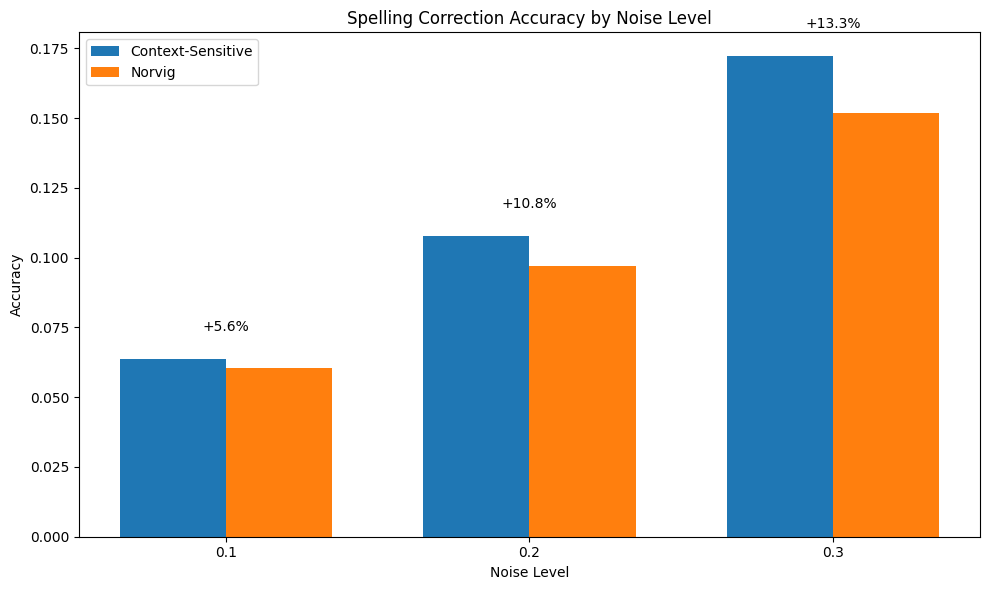

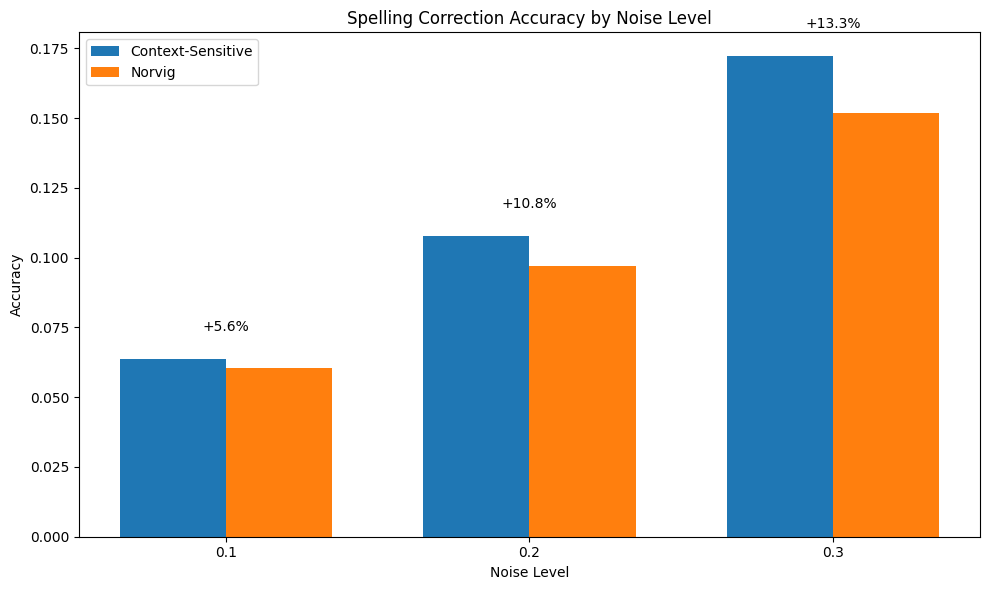

In [5]:
def analyze_results():
    import matplotlib.pyplot as plt
    
    noise_levels = [0.1, 0.2, 0.3]
    context_accuracies = [0.0638, 0.1076, 0.1721]  # From our test results
    norvig_accuracies = [0.0604, 0.0971, 0.1519]
    
    x = range(len(noise_levels))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    context_bars = ax.bar([i - width/2 for i in x], context_accuracies, width, label='Context-Sensitive')
    norvig_bars = ax.bar([i + width/2 for i in x], norvig_accuracies, width, label='Norvig')
    
    ax.set_xlabel('Noise Level')
    ax.set_ylabel('Accuracy')
    ax.set_title('Spelling Correction Accuracy by Noise Level')
    ax.set_xticks(x)
    ax.set_xticklabels([f'{level:.1f}' for level in noise_levels])
    ax.legend()
    
    for i in range(len(noise_levels)):
        improvement = (context_accuracies[i] - norvig_accuracies[i]) / norvig_accuracies[i] * 100
        ax.text(i, max(context_accuracies[i], norvig_accuracies[i]) + 0.01, 
                f'+{improvement:.1f}%', ha='center')
    
    plt.tight_layout()
    return fig

analyze_results()

#### Useful resources (also included in the archive in moodle):

1. [Possible dataset with N-grams](https://www.ngrams.info/download_coca.asp)
2. [Damerau–Levenshtein distance](https://en.wikipedia.org/wiki/Damerau–Levenshtein_distance#:~:text=Informally%2C%20the%20Damerau–Levenshtein%20distance,one%20word%20into%20the%20other.)